In [1]:
!/opt/bin/nvidia-smi

Tue Mar  8 14:05:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!pip install jsonlines

In [4]:
root_path = "/content/drive/My Drive/nlp-beginner/task3/"

In [5]:
import jsonlines as jl
from torch.utils.data import Dataset, DataLoader
import pickle
import collections
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchtext.vocab import vocab
from collections import OrderedDict
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import torch.nn as nn
import torchtext.vocab as Vocab
import os

pad_id = 0
not_found_id = 1


class SentPairDataset(Dataset):
    def __init__(self, data_path, max_len, data_mode, nums=-1):
        '''
        :param data_path: 数据集路径
        :param w2id_dict: word2id的字典
        :param max_len: 要求截断或填充至的句子长度
        :param data_mode: train or test，用于命名文件
        '''
        self.labels = load_data_from_jsonl(data_path, only_labels=True)[:nums]
        sents1_and_len = load_sents_and_len(root_path + "data/" + data_mode + "_sent1")
        sents2_and_len = load_sents_and_len(root_path + "data/" + data_mode + "_sent2")
        self.sent1_list = np.array(sents1_and_len["sents"][:nums])
        self.sent2_list = np.array(sents2_and_len["sents"][:nums])
        self.sent1_lens = np.array(sents1_and_len["sents_length"][:nums])
        self.sent2_lens = np.array(sents2_and_len["sents_length"][:nums])
        # self.sent1_list = torch.from_numpy(self.sent1_list).type(torch.LongTensor)
        # self.sent2_list = torch.from_numpy(self.sent2_list).type(torch.LongTensor)
        # self.sent1_lens = torch.from_numpy(self.sent1_lens).type(torch.LongTensor)
        # self.sent2_lens = torch.from_numpy(self.sent2_lens).type(torch.LongTensor)
        self.sent1_list = torch.from_numpy(self.sent1_list)
        self.sent2_list = torch.from_numpy(self.sent2_list)
        self.sent1_lens = torch.from_numpy(self.sent1_lens)
        self.sent2_lens = torch.from_numpy(self.sent2_lens)
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sent1_list[idx], self.sent1_lens[idx], self.sent2_list[idx], \
               self.sent2_lens[idx], self.labels[idx]


def load_data_from_jsonl(file_name, only_labels=False):
    labels2id = {"entailment": 0, "neutral": 1, "contradiction": 2}
    labels = []
    if only_labels:
        with open(file_name, "r+") as f:
            for row in jl.Reader(f):
                if row["gold_label"] != "-":
                    labels.append(labels2id[row["gold_label"]])
        return labels
    sentence1_list = []
    sentence2_list = []
    with open(file_name, "r+") as f:
        for row in jl.Reader(f):
            if row["gold_label"] != "-":
                labels.append(labels2id[row["gold_label"]])
                sentence1_list.append(row["sentence1"])
                sentence2_list.append(row["sentence2"])
    return sentence1_list, sentence2_list, labels


def sents2matrix(sents, w2id_dict, max_len, if_save=False, save_path=None):
    tokenized_data = get_tokenized_sent(sents)
    sents_length = [min(len(sent), max_len) for sent in tokenized_data]
    matrix = []
    for words in tqdm(tokenized_data):
        matrix.append(words2id(w2id_dict, words, max_len))
    sents_and_len = {"sents": matrix, "sents_length": sents_length}
    if if_save:
        f = open(save_path, 'wb')
        pickle.dump(sents_and_len, f)
        print("----------------------词id矩阵及句长" + save_path + " 存储完毕----------------------")
    return sents_and_len


def load_sents_and_len(data_path):
    # Restore from a file
    f = open(data_path, 'rb')
    sents_and_len = pickle.load(f)
    return sents_and_len


# 分词
def get_tokenized_sent(sents):
    stopWords = set(stopwords.words('english'))
    def tokenizer(text):
        words = word_tokenize(text)
        words = [word.lower() for word in words
                 if word.isalpha() and word not in stopWords]
        return words
    return [tokenizer(review) for review in sents]


# 获得数据集的词典
def get_vocab(sents, min_feq=3, if_save=False, save_path="vocab"):
    tokenized_data = get_tokenized_sent(sents)
    counter = collections.Counter([tk for st in tokenized_data for tk in st])
    sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    idx = len(sorted_by_freq_tuples) - 1
    while sorted_by_freq_tuples[idx][1] < min_feq:
        sorted_by_freq_tuples.pop(idx)
        idx -= 1
    # 用<NOF>表示未找到的词
    sorted_by_freq_tuples.insert(0, ('<NOF>', 1))
    # 用<PAD>表示被填充的位置，序号为0
    sorted_by_freq_tuples.insert(0, ("<PAD>", 1))

    ordered_dict = OrderedDict(sorted_by_freq_tuples)
    vocab_obj = vocab(ordered_dict)
    print("字典大小： ", len(vocab_obj))
    if if_save:
        f = open(save_path, 'wb')
        pickle.dump(vocab_obj, f)
        print("----------------------字典存储完毕----------------------")
    return vocab_obj


def load_vocab(vocab_path):
    # Restore from a file
    f = open(vocab_path, 'rb')
    vocab_obj = pickle.load(f)
    return vocab_obj


def words2id(vocab_dic, words, max_len):
    def pad(x):
        return x[:max_len] if len(x) > max_len else x + [pad_id] * (max_len - len(x))

    vec = []
    not_found_id = 1
    for word in words:
        try:
            vec.append(vocab_dic[word])
        except KeyError:
            vec.append(not_found_id)
    return pad(vec)


def analysis_len(sents):
    sents_len = [len(sent) for sent in sents]
    sents_len = sorted(sents_len)
    nums = len(sents_len)
    print("70%: ", sents_len[int(0.7 * nums)])
    print("80%: ", sents_len[int(0.8 * nums)])
    print("90%: ", sents_len[int(0.9 * nums)])
    print("95%: ", sents_len[int(0.95 * nums)])
    print("99%: ", sents_len[int(0.99 * nums)])
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.figure(figsize=(30, 12), dpi=100)
    plt.subplot(2, 3, 2)
    plt.title("句子长度分布")
    plt.hist(sents_len, bins=list(range(0, max(sents_len) + 1, 1)))
    plt.xlabel('句子长度')
    plt.ylabel('句子数量')
    """ title 累计分布"""
    plt.subplot(2, 3, 5)
    plt.title('累计分布图')
    plt.hist(sents_len, bins=list(range(0, max(sents_len) + 1, 1)), cumulative=True)
    plt.xlabel('句子长度')
    plt.ylabel('累计比例(%)')
    plt.savefig("sent_len.png")


def sort_by_seq_lens(batch, sequences_lengths, descending=True):
    sorted_seq_lens, sorting_index = \
        sequences_lengths.sort(0, descending=descending)

    sorted_batch = batch.index_select(0, sorting_index)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    idx_range = \
        sequences_lengths.new_tensor(torch.arange(0, len(sequences_lengths)))
    idx_range = idx_range.to(device)
    _, reverse_mapping = sorting_index.sort(0, descending=False)
    # reverse_mapping.to(device)
    # print("idx_range: ", idx_range.device)
    # print("reverse_mapping: ", reverse_mapping.device)
    restoration_index = idx_range.index_select(0, reverse_mapping)

    return sorted_batch, sorted_seq_lens, sorting_index, restoration_index


def get_mask(sequences_batch, sequences_lengths):
    """
    对一个批量填充过的句子计算mask矩阵
    Args:
        sequences_batch: size：(batch, max_len).
        sequences_lengths: 'sequences_batch'中每个句子的长度，size：(batch).
    Returns:
        mask矩阵，size：(batch, max_sequence_length)
        其中max_sequence_length是批量中最长句子的长度
    """
    batch_size = sequences_batch.size()[0]
    max_length = torch.max(sequences_lengths)
    mask = torch.ones(batch_size, max_length, dtype=torch.int)
    mask[sequences_batch[:, :max_length] == 0] = 0.0
    return mask


def get_atten_mask(sequences_batch, sequences_lengths):
    batch_size = sequences_batch.size()[0]
    max_length = torch.max(sequences_lengths)
    mask = torch.zeros(batch_size, max_length, dtype=torch.float)
    mask[sequences_batch[:, :max_length] == 0] = 1.0
    return mask


def masked_softmax(tensor, mask):
    tensor_shape = tensor.size()
    reshaped_tensor = tensor.view(-1, tensor_shape[-1])

    # Reshape the mask so it matches the size of the input tensor.
    while mask.dim() < tensor.dim():
        mask = mask.unsqueeze(1)
    mask = mask.expand_as(tensor).contiguous().float()
    reshaped_mask = mask.view(-1, mask.size()[-1])

    result = nn.functional.softmax(reshaped_tensor * reshaped_mask, dim=-1)
    result = result * reshaped_mask
    # 1e-13 is added to avoid divisions by zero.
    result = result / (result.sum(dim=-1, keepdim=True) + 1e-13)

    return result.view(*tensor_shape)


def weighted_sum(tensor, weights, mask):

    weighted_sum = weights.bmm(tensor)

    while mask.dim() < weighted_sum.dim():
        mask = mask.unsqueeze(1)
    mask = mask.transpose(-1, -2)
    mask = mask.expand_as(weighted_sum).contiguous().float()

    return weighted_sum * mask


def replace_masked(tensor, mask, value):
    mask = mask.unsqueeze(1).transpose(2, 1)
    reverse_mask = 1.0 - mask
    values_to_add = value * reverse_mask
    return tensor * mask + values_to_add
    
    
def load_pretrained_embedding(words, pretrained_vocab):
    '''从预训练好的vocab中提取出words对应的词向量'''
    embed = torch.zeros(len(words), pretrained_vocab.vectors[0].shape[0]) # 初始化为0
    oov_count = 0 # out of vocabulary
    for i, word in enumerate(words):
        try:
            idx = pretrained_vocab.stoi[word]
            embed[i, :] = pretrained_vocab.vectors[idx]
        except KeyError:
            oov_count += 1
    if oov_count > 0:
        print("There are %d oov words." % oov_count)
    return embed

In [6]:
class ESIM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, embeddings=None,
                 padding_idx=0, dropout=0.5, num_classes=3):
        """
        Args:
            vocab_size: 词表大小
            embed_dim: 词嵌入维度
            hidden_size: 隐藏层维度
            embeddings: 预训练的词向量，若为None则随机初始化
            padding_idx:  padding token的序号，默认为0
            dropout: 全连接层的dropout比例，默认为0.5
            num_classes: 输出层的类别，默认为3
            device: 默认为cpu
        """
        super(ESIM, self).__init__()

        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.dropout = dropout
        # 嵌入层
        self.word_embedding = nn.Embedding(self.vocab_size, self.embed_dim, padding_idx=padding_idx)
        if embeddings:
            # 加载预训练的词嵌入
            embvecs, embwords = embeddings
            self.word_embedding.weight.data.copy_(torch.from_numpy(np.asarray(embvecs)))
        # self.word_embedding.weight.requires_grad = False

        if self.dropout:
            self.rnn_dropout = RNNDropout(p=self.dropout)
            # self._rnn_dropout = nn.Dropout(p=self.dropout)

        # Encoder，由双向LSTM实现
        self.encoding = Seq2SeqEncoder(nn.LSTM, self.embed_dim,
                                       self.hidden_size, bidirectional=True)

        # 软性注意力，使用点积模型
        self.attention = SoftmaxAttention()
        # 使用ReLU作为激活函数的全连接层
        self.projection = nn.Sequential(nn.Linear(4 * 2 * self.hidden_size,
                                                  self.hidden_size), nn.ReLU())
        # 双向LSTM
        self.composition = Seq2SeqEncoder(nn.LSTM, self.hidden_size,
                                          self.hidden_size, bidirectional=True)
        # 分类器
        # 一个隐藏层，以tanh为激活函数，进行dropout
        self.classification = nn.Sequential(nn.Dropout(p=self.dropout),
                                            nn.Linear(2 * 4 * self.hidden_size, self.hidden_size),
                                            nn.Tanh(),
                                            nn.Dropout(p=self.dropout),
                                            nn.Linear(self.hidden_size, self.num_classes))
        # Initialize all weights and biases in the model.
        self.apply(_init_esim_weights)

    def forward(self,
                sent1_ids,
                sent2_ids,
                sent1_lens=None,
                sent2_lens=None,
                device='cpu'
                ):
        """
        :param sent1_ids:   句子1，维度 (batch_size, max_len).
        :param sent2_ids:   句子2，维度 (batch_size, max_len).
        :param sent1_lens:  句子1batch中每个句子的长度，一维张量
        :param sent2_lens:  句子2batch中每个句子的长度，一维张量
        :param device:      运行设备
        :return:
            logits: A tensor of size (batch, num_classes) containing the logits for each output class of the model.
            probabilities: A tensor of size (batch, num_classes) containing the probabilities of each output class in the model.

        """


        # premises = text_a_ids
        # premises_lengths = q1_lens
        # hypotheses = text_b_ids
        # hypotheses_lengths = q2_lens

        # 计算两个句子的mask
        # mask's size：(batch, max_seq_len)
        # 其中max_seq_len是批量中最长句子的长度
        sent1_mask = get_mask(sent1_ids, sent1_lens).to(device)
        sent2_mask = get_mask(sent2_ids, sent2_lens).to(device)

        # 得到词嵌入矩阵
        # embedded_sent's size：(batch_size, max_len, embed_size)
        embedded_sent1 = self.word_embedding(sent1_ids)
        embedded_sent2 = self.word_embedding(sent2_ids)

        # 对RNN的输入进行dropout，丢掉一部分输入（置为0）
        if self.dropout:
            embedded_sent1 = self.rnn_dropout(embedded_sent1)
            embedded_sent2 = self.rnn_dropout(embedded_sent2)
        # 使用双向LSTM对词嵌入进行初步编码
        # encoded_sent's size : (batch_size, max_seq_len, embed_size * 2)
        encoded_sent1 = self.encoding(embedded_sent1, sent1_lens)
        encoded_sent2 = self.encoding(embedded_sent2, sent2_lens)

        # 使用软性注意力计算得到注意力加权后的编码
        # mask1：在相似度矩阵中将pad元素所在的位置全部置为0，再经过softmax，再将pad元素所在的位置全部置为0
        # mask2：在将词嵌入进行加权后，将pad元素所在的位置全部置为0
        # attended_sent's size : (batch_size, max_seq_len, embed_size * 2)
        attended_sent1, attended_sent2 = self.attention(encoded_sent1, sent1_mask,
                                                        encoded_sent2, sent2_mask)
        # 将原编码、注意力编码、它们的差、它们的哈达玛积进行拼接
        # enhanced_sent's size : (batch_size, max_seq_len, embed_size * 8)
        enhanced_sent1 = torch.cat([encoded_sent1,
                                    attended_sent1,
                                    encoded_sent1 - attended_sent1,
                                    encoded_sent1 * attended_sent1],
                                    dim=-1)
        enhanced_sent2 = torch.cat([encoded_sent2,
                                    attended_sent2,
                                    encoded_sent2 - attended_sent2,
                                    encoded_sent2 * attended_sent2],
                                    dim=-1)

        # 全连接映射层，减少参数
        # projected_sent's size : (batch_size, max_seq_len, embed_size)
        projected_sent1 = self.projection(enhanced_sent1)
        projected_sent2 = self.projection(enhanced_sent2)

        # 对RNN的输入进行dropout
        if self.dropout:
            projected_sent1 = self.rnn_dropout(projected_sent1)
            projected_sent2 = self.rnn_dropout(projected_sent2)

        # 经过双向LSTM
        # size : (batch_size, max_seq_len, 2 * embed_size)
        v_ai = self.composition(projected_sent1, sent1_lens)
        v_bj = self.composition(projected_sent2, sent2_lens)

        # 平均池化
        # size: (batch_size, 2 * embed_size)
        v_a_avg = torch.sum(v_ai * sent1_mask.unsqueeze(1)
                            .transpose(2, 1), dim=1) \
                  / torch.sum(sent1_mask, dim=1, keepdim=True)
        v_b_avg = torch.sum(v_bj * sent2_mask.unsqueeze(1)
                            .transpose(2, 1), dim=1) \
                  / torch.sum(sent2_mask, dim=1, keepdim=True)
        # 最大池化
        v_a_max, _ = replace_masked(v_ai, sent1_mask, -1e7).max(dim=1)
        v_b_max, _ = replace_masked(v_bj, sent2_mask, -1e7).max(dim=1)
        # 拼接
        # v's size : (batch_size, 2 * 4 * embed_size)
        v = torch.cat([v_a_avg, v_a_max, v_b_avg, v_b_max], dim=1)

        # 输出
        # size : (batch_size, num_inputs)
        logits = self.classification(v)
        # probabilities = nn.functional.softmax(logits, dim=-1)

        return logits


class RNNDropout(nn.Dropout):
    def forward(self, sequences_batch):
        ones = sequences_batch.data.new_ones(sequences_batch.shape[0],
                                             sequences_batch.shape[-1])
        dropout_mask = nn.functional.dropout(ones, self.p, self.training,
                                             inplace=False)
        return dropout_mask.unsqueeze(1) * sequences_batch


class Seq2SeqEncoder(nn.Module):
    def __init__(self,
                 rnn_type,
                 input_size,
                 hidden_size,
                 num_layers=1,
                 bias=True,
                 dropout=0.0,
                 bidirectional=False):
        assert issubclass(rnn_type, nn.RNNBase), \
            "rnn_type must be a class inheriting from torch.nn.RNNBase"

        super(Seq2SeqEncoder, self).__init__()

        self.rnn_type = rnn_type
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.dropout = dropout
        self.bidirectional = bidirectional

        self._encoder = rnn_type(input_size,
                                 hidden_size,
                                 num_layers=num_layers,
                                 bias=bias,
                                 batch_first=True,
                                 dropout=dropout,
                                 bidirectional=bidirectional)

    def forward(self, sequences_batch, sequences_lengths):
        sorted_batch, sorted_lengths, _, restoration_idx = \
            sort_by_seq_lens(sequences_batch, sequences_lengths)
        try:
            packed_batch = nn.utils.rnn.pack_padded_sequence(sorted_batch,
                                                         sorted_lengths.cpu(),
                                                         batch_first=True)
        except:
            import pdb
            pdb.set_trace()
        outputs, _ = self._encoder(packed_batch, None)

        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs,
                                                      batch_first=True)
        reordered_outputs = outputs.index_select(0, restoration_idx)

        return reordered_outputs


class SoftmaxAttention(nn.Module):
    """
    Attention layer
    接受RNN对句子的编码作为输入，输出软性注意力
    首先计算两个句子向量的点积，softmax后的结果作为权重
    句子2向量的加权和将用来表示句子1
    反之，句子1向量的加权和将用来表示句子2
    """
    def forward(self,
                premise_batch,
                premise_mask,
                hypothesis_batch,
                hypothesis_mask):
        """
        Args:
            premise_batch: A batch of sequences of vectors representing the
                premises in some NLI task. The batch is assumed to have the
                size (batch, max_seq_len, vector_dim).
            premise_mask: 用于在计算注意力时，忽略掉padding的0
            hypothesis_batch: A batch of sequences of vectors representing the
                hypotheses in some NLI task. The batch is assumed to have the
                size (batch, max_seq_len, vector_dim).
            hypothesis_mask: 用于在计算注意力时，忽略掉padding的0
        """
        # Dot product between premises and hypotheses in each sequence of
        # the batch.
        # batch (max_seq_len1, vector_dim) 乘 batch (vector_dim, max_seq_len2) = (batch, max_seq_len1, max_seq_len2)
        similarity_matrix = premise_batch.bmm(hypothesis_batch.transpose(2, 1)
                                              .contiguous())

        # Softmax attention 权重
        # mask1：在相似度矩阵中将pad元素所在的位置全部置为0，再经过softmax，再将pad元素所在的位置全部置为0
        prem_hyp_attn = masked_softmax(similarity_matrix, hypothesis_mask)
        hyp_prem_attn = masked_softmax(similarity_matrix.transpose(1, 2)
                                       .contiguous(),
                                       premise_mask)

        # Weighted sums of the hypotheses for the the premises attention,
        # and vice-versa for the attention of the hypotheses.
        # mask2：在将词嵌入进行加权后，将pad元素所在的位置全部置为0

        attended_premises = weighted_sum(hypothesis_batch,
                                         prem_hyp_attn,
                                         premise_mask)
        attended_hypotheses = weighted_sum(premise_batch,
                                           hyp_prem_attn,
                                           hypothesis_mask)

        return attended_premises, attended_hypotheses


def _init_esim_weights(module):
    """
    Initialise the weights of the ESIM model.
    """
    if isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight.data)
        nn.init.constant_(module.bias.data, 0.0)

    elif isinstance(module, nn.LSTM):
        nn.init.kaiming_normal_(module.weight_ih_l0.data)
        nn.init.orthogonal_(module.weight_hh_l0.data)
        nn.init.constant_(module.bias_ih_l0.data, 0.0)
        nn.init.constant_(module.bias_hh_l0.data, 0.0)
        hidden_size = module.bias_hh_l0.data.shape[0] // 4
        module.bias_hh_l0.data[hidden_size:(2 * hidden_size)] = 1.0

        if (module.bidirectional):
            nn.init.kaiming_normal_(module.weight_ih_l0_reverse.data)
            nn.init.orthogonal_(module.weight_hh_l0_reverse.data)
            nn.init.constant_(module.bias_ih_l0_reverse.data, 0.0)
            nn.init.constant_(module.bias_hh_l0_reverse.data, 0.0)
            module.bias_hh_l0_reverse.data[hidden_size:(2 * hidden_size)] = 1.0

In [12]:
from torch.utils.data import DataLoader
import time
import torch.nn as nn
import os 

root_path = "/content/drive/My Drive/nlp-beginner/task3/"
train_path = root_path + "data/snli_1.0_train.jsonl"
test_path = root_path + "data/snli_1.0_dev.jsonl"
vocab_path = root_path + "data/vocab"
max_len = 25
batch_size = 64
vocab = load_vocab(vocab_path)  # 加载字典
vocab_size = len(vocab)
embed_dim = 300
hidden_size = 300
lr = 0.0004
num_epochs = 50
model_path = root_path + "models_file/"

""" 设置随机种子 """
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

There are 1327 oov words.
training on  cuda:0


100%|██████████| 8584/8584 [04:24<00:00, 32.49it/s]


epoch 1, loss 0.7268, train acc 0.687, test acc 0.795, time 265.9 sec


100%|██████████| 8584/8584 [04:23<00:00, 32.55it/s]


epoch 2, loss 0.2853, train acc 0.774, test acc 0.821, time 265.5 sec


100%|██████████| 8584/8584 [04:22<00:00, 32.69it/s]


epoch 3, loss 0.1738, train acc 0.797, test acc 0.836, time 264.3 sec


100%|██████████| 8584/8584 [04:22<00:00, 32.66it/s]


epoch 4, loss 0.1228, train acc 0.810, test acc 0.844, time 264.6 sec


100%|██████████| 8584/8584 [04:24<00:00, 32.48it/s]


epoch 5, loss 0.0937, train acc 0.820, test acc 0.848, time 266.0 sec


100%|██████████| 8584/8584 [04:22<00:00, 32.72it/s]


epoch 6, loss 0.0754, train acc 0.828, test acc 0.851, time 264.0 sec


100%|██████████| 8584/8584 [04:22<00:00, 32.71it/s]


epoch 7, loss 0.0626, train acc 0.835, test acc 0.852, time 264.2 sec


100%|██████████| 8584/8584 [04:21<00:00, 32.84it/s]


epoch 8, loss 0.0532, train acc 0.840, test acc 0.855, time 263.1 sec


100%|██████████| 8584/8584 [04:21<00:00, 32.77it/s]


epoch 9, loss 0.0462, train acc 0.846, test acc 0.855, time 263.7 sec


100%|██████████| 8584/8584 [04:21<00:00, 32.85it/s]


epoch 10, loss 0.0406, train acc 0.850, test acc 0.854, time 263.0 sec


100%|██████████| 8584/8584 [04:21<00:00, 32.84it/s]


epoch 11, loss 0.0361, train acc 0.853, test acc 0.862, time 263.1 sec


100%|██████████| 8584/8584 [04:21<00:00, 32.85it/s]


epoch 12, loss 0.0326, train acc 0.855, test acc 0.860, time 263.0 sec


100%|██████████| 8584/8584 [04:21<00:00, 32.78it/s]


epoch 13, loss 0.0296, train acc 0.858, test acc 0.860, time 263.6 sec


100%|██████████| 8584/8584 [04:22<00:00, 32.76it/s]


epoch 14, loss 0.0271, train acc 0.861, test acc 0.859, time 263.8 sec


100%|██████████| 8584/8584 [04:23<00:00, 32.64it/s]


epoch 15, loss 0.0249, train acc 0.863, test acc 0.858, time 264.7 sec


100%|██████████| 8584/8584 [04:21<00:00, 32.78it/s]


epoch 16, loss 0.0230, train acc 0.866, test acc 0.861, time 263.6 sec


100%|██████████| 8584/8584 [04:20<00:00, 32.98it/s]


epoch 17, loss 0.0213, train acc 0.868, test acc 0.862, time 262.0 sec


100%|██████████| 8584/8584 [04:19<00:00, 33.08it/s]


epoch 18, loss 0.0199, train acc 0.870, test acc 0.862, time 261.2 sec


100%|██████████| 8584/8584 [04:18<00:00, 33.21it/s]


epoch 19, loss 0.0187, train acc 0.871, test acc 0.858, time 260.2 sec


100%|██████████| 8584/8584 [04:19<00:00, 33.13it/s]


epoch 20, loss 0.0175, train acc 0.873, test acc 0.861, time 260.8 sec


100%|██████████| 8584/8584 [04:19<00:00, 33.08it/s]


epoch 21, loss 0.0165, train acc 0.875, test acc 0.862, time 261.2 sec


100%|██████████| 8584/8584 [04:19<00:00, 33.08it/s]


epoch 22, loss 0.0156, train acc 0.876, test acc 0.859, time 261.2 sec


100%|██████████| 8584/8584 [04:19<00:00, 33.13it/s]


epoch 23, loss 0.0148, train acc 0.877, test acc 0.857, time 260.8 sec


100%|██████████| 8584/8584 [04:18<00:00, 33.16it/s]


epoch 24, loss 0.0141, train acc 0.878, test acc 0.859, time 260.6 sec


100%|██████████| 8584/8584 [04:19<00:00, 33.03it/s]


epoch 25, loss 0.0134, train acc 0.879, test acc 0.859, time 261.6 sec


100%|██████████| 8584/8584 [04:18<00:00, 33.15it/s]


epoch 26, loss 0.0128, train acc 0.881, test acc 0.859, time 260.6 sec


100%|██████████| 8584/8584 [04:18<00:00, 33.20it/s]


epoch 27, loss 0.0122, train acc 0.882, test acc 0.859, time 260.2 sec


100%|██████████| 8584/8584 [04:18<00:00, 33.27it/s]


epoch 28, loss 0.0117, train acc 0.882, test acc 0.856, time 259.7 sec


100%|██████████| 8584/8584 [04:19<00:00, 33.02it/s]


epoch 29, loss 0.0112, train acc 0.883, test acc 0.859, time 261.7 sec


100%|██████████| 8584/8584 [04:20<00:00, 33.00it/s]


epoch 30, loss 0.0108, train acc 0.884, test acc 0.859, time 261.8 sec


100%|██████████| 8584/8584 [04:19<00:00, 33.11it/s]


epoch 31, loss 0.0104, train acc 0.885, test acc 0.858, time 260.9 sec


100%|██████████| 8584/8584 [04:20<00:00, 32.94it/s]


epoch 32, loss 0.0099, train acc 0.886, test acc 0.858, time 262.3 sec


100%|██████████| 8584/8584 [04:18<00:00, 33.23it/s]


epoch 33, loss 0.0096, train acc 0.887, test acc 0.856, time 260.0 sec


100%|██████████| 8584/8584 [04:18<00:00, 33.16it/s]


epoch 34, loss 0.0093, train acc 0.887, test acc 0.856, time 260.6 sec


100%|██████████| 8584/8584 [04:19<00:00, 33.12it/s]


epoch 35, loss 0.0089, train acc 0.888, test acc 0.856, time 260.8 sec


100%|██████████| 8584/8584 [04:19<00:00, 33.09it/s]


epoch 36, loss 0.0087, train acc 0.889, test acc 0.857, time 261.0 sec


100%|██████████| 8584/8584 [04:19<00:00, 33.07it/s]


epoch 37, loss 0.0084, train acc 0.889, test acc 0.859, time 261.3 sec


100%|██████████| 8584/8584 [04:19<00:00, 33.03it/s]


epoch 38, loss 0.0082, train acc 0.890, test acc 0.858, time 261.6 sec


100%|██████████| 8584/8584 [04:19<00:00, 33.13it/s]


epoch 39, loss 0.0079, train acc 0.891, test acc 0.857, time 260.8 sec


100%|██████████| 8584/8584 [04:20<00:00, 32.93it/s]


epoch 40, loss 0.0077, train acc 0.890, test acc 0.860, time 262.4 sec


100%|██████████| 8584/8584 [04:20<00:00, 32.99it/s]


epoch 41, loss 0.0075, train acc 0.892, test acc 0.855, time 261.9 sec


100%|██████████| 8584/8584 [04:20<00:00, 32.97it/s]


epoch 42, loss 0.0073, train acc 0.891, test acc 0.858, time 262.0 sec


100%|██████████| 8584/8584 [04:20<00:00, 32.98it/s]


epoch 43, loss 0.0071, train acc 0.892, test acc 0.857, time 262.0 sec


100%|██████████| 8584/8584 [04:19<00:00, 33.03it/s]


epoch 44, loss 0.0069, train acc 0.893, test acc 0.856, time 261.6 sec


100%|██████████| 8584/8584 [04:20<00:00, 32.97it/s]


epoch 45, loss 0.0067, train acc 0.893, test acc 0.860, time 262.1 sec


100%|██████████| 8584/8584 [04:20<00:00, 33.01it/s]


epoch 46, loss 0.0066, train acc 0.893, test acc 0.861, time 261.7 sec


100%|██████████| 8584/8584 [04:20<00:00, 32.94it/s]


epoch 47, loss 0.0064, train acc 0.894, test acc 0.857, time 262.3 sec


100%|██████████| 8584/8584 [04:19<00:00, 33.03it/s]


epoch 48, loss 0.0063, train acc 0.894, test acc 0.859, time 261.6 sec


100%|██████████| 8584/8584 [04:19<00:00, 33.05it/s]


epoch 49, loss 0.0061, train acc 0.893, test acc 0.856, time 261.4 sec


100%|██████████| 8584/8584 [04:19<00:00, 33.02it/s]


epoch 50, loss 0.0060, train acc 0.894, test acc 0.855, time 261.7 sec


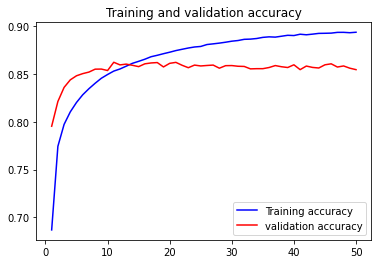

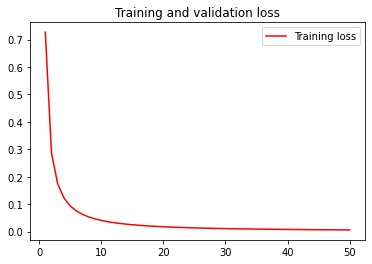

In [ ]:
def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs, max_gradient_norm):
    net = net.to(device)
    print("training on ", device)
    batch_count = 0
    loss_epochs = []
    acc_epochs = []
    test_acc_epochs = []
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        process_bar = tqdm(train_iter)
        for (s1, s1_len, s2, s2_len, labels) in process_bar:
            s1 = s1.to(device)
            s1_len = s1_len.to(device)
            s2 = s2.to(device)
            s2_len = s2_len.to(device)
            s2_len = s2_len.to(device)
            labels = labels.to(device)
            
            y_hat = net(s1, s2, s1_len, s2_len, device)
            l = loss(y_hat, labels)
            optimizer.zero_grad()
            l.backward()
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_gradient_norm)
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().cpu().item()
            n += labels.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        loss_epochs.append(train_l_sum / batch_count)
        acc_epochs.append(train_acc_sum / n)
        test_acc_epochs.append(test_acc)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
        torch.save({"epoch": epoch,
                    "model": net.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "epochs_count": epoch,
                    "train_losses": train_l_sum / batch_count}, 
                    os.path.join(model_path, "esim_epoch_{}.pth.tar".format(epoch)))
    save_img(loss_epochs, acc_epochs, test_acc_epochs)


def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        # process_bar = tqdm(data_iter)
        # process_bar.set_description("test")
        for _, (s1, s1_len, s2, s2_len, labels) in enumerate(data_iter):
            s1 = s1.to(device)
            s1_len = s1_len.to(device)
            s2 = s2.to(device)
            s2_len = s2_len.to(device)
            labels = labels.to(device)
            net.eval()  # 评估模式, 这会关闭dropout
            acc_sum += (net(s1, s2, s1_len, s2_len, device).argmax(dim=1) == labels.to(device)).float().sum().cpu().item()
            net.train()  # 改回训练模式
            n += labels.shape[0]
    return acc_sum / n


def save_img(loss, acc, test_acc):
    num_epochs = len(loss)
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, test_acc, 'r', label='validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc='lower right')
    plt.figure()
    plt.savefig("acc1.png")

    plt.plot(epochs, loss, 'r', label='Training loss')
    # plt.plot(epochs, val_loss, 'b', label='validation loss')
    plt.title('Training and validation loss')m
    plt.legend()
    plt.savefig("loss1.png")


def main():
    # w2id_dic = vocab.get_stoi()
    train_set = SentPairDataset(train_path, max_len, data_mode="train")
    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    test_set = SentPairDataset(test_path, max_len, data_mode="test")
    test_loader = DataLoader(test_set, batch_size, shuffle=True)

    model = ESIM(vocab_size, embed_dim, hidden_size)
    glove_vocab = Vocab.GloVe(name='6B', dim=embed_dim, cache=os.path.join(root_path + "data", "glove"))
    # 加载Glove词向量
    model.word_embedding.weight.data.copy_(load_pretrained_embedding(vocab.get_itos(), glove_vocab))

    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                                 lr=lr, betas=(0.9, 0.999))
    # train(test_loader, test_loader, model, loss, optimizer, device, num_epochs, 10)
    train(train_loader, test_loader, model, loss, optimizer, device, num_epochs, 10)
    

if __name__ == "__main__":
    main()